# Chapter 2: NetCDF and BPCH diagnostics in GEOS-Chem

**Prerequisite**: Minimal xarray knowledge in [Chapter01_NetCDF_xarray.ipynb](./Chapter01_NetCDF_xarray.ipynb).

As every GEOS-Chem user knows, [BPCH](http://wiki.seas.harvard.edu/geos-chem/index.php/List_of_diagnostics_archived_to_bpch_format) has been the major diagnostics format. An important structural update in [GEOS-Chem v11-02](http://wiki.seas.harvard.edu/geos-chem/index.php/GEOS-Chem_v11-02) is the ability to write [NetCDF diagnostics](http://wiki.seas.harvard.edu/geos-chem/index.php/List_of_diagnostics_archived_to_netCDF_format). This is a big thing -- it allows [GCHP](http://wiki.seas.harvard.edu/geos-chem/index.php/GEOS-Chem_HP) to use **exactly the same diagnostics interface** and output **all available diagnotics as in GEOS-Chem-classic**. The new user interface is also much more user-friendly than the old interface.

**Xarray is able to read both formats**. So you don't need to use IDL/gamap at all even if you need the old BPCH module. This is made possible by the [xbpch package](http://xbpch.readthedocs.io/en/latest/) written by Daniel Rothenberg.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xbpch

import warnings; warnings.filterwarnings("ignore")  # hide some xbpch warnings

from gamap_colormap import WhGrYlRd

# NetCDF diagnostics

We provide a pre-generated diagnostics file in this directory. For how to configure what diagnostics to output, please see [GEOS-Chem wiki](http://wiki.seas.harvard.edu/geos-chem/index.php/List_of_diagnostics_archived_to_netCDF_format).

In [2]:
ds_nc = xr.open_dataset("new-NC-diagnostics.nc4")
ds_nc

<xarray.Dataset>
Dimensions:         (ilev: 73, lat: 46, lev: 72, lon: 72, time: 3)
Coordinates:
  * time            (time) datetime64[ns] 2013-07-01T00:20:00 ...
  * lev             (lev) float64 0.9925 0.9775 0.9625 0.9475 0.9325 0.9175 ...
  * ilev            (ilev) float64 1.0 0.985 0.97 0.955 0.94 0.925 0.91 ...
  * lat             (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 ...
  * lon             (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 ...
Data variables:
    hyam            (lev) float64 ...
    hybm            (lev) float64 ...
    hyai            (ilev) float64 ...
    hybi            (ilev) float64 ...
    P0              float64 ...
    AREA            (lat, lon) float32 ...
    SpeciesConc_CO  (time, lev, lat, lon) float32 ...
    SpeciesConc_O3  (time, lev, lat, lon) float32 ...
    SpeciesConc_NO  (time, lev, lat, lon) float32 ...
Attributes:
    title:         GEOS-Chem diagnostic collection: inst
    history:       
    format:        not fo

The corresponding config file in the run directory (called `HISTORY.rc`, which is also used for GCHP!) looks like:

```
COLLECTIONS: 'inst',
              ::
  inst.template:  '%y4%m2%d2.nc4',
  inst.frequency:  002000,
  inst.duration:   240000,
  inst.mode:      'instantaneous',
  inst.fields:    'SpeciesConc_NO',           'GIGCchem',
                  'SpeciesConc_O3',           'GIGCchem',
                  'SpeciesConc_CO',           'GIGCchem',
                   ::
```

Here I let the model to output the instantaneous concentrations (`inst.mode: 'instantaneous'`) of 3 species: NO, O3 and CO, with a frequency of 20 minutes (`inst.frequency`). A new file is generated every 24 hours (`inst.duration`)

Each variable contains 3 time slices, since I run the model for 1 hour and a time slice is written out every 20min.

In [3]:
ds_nc['SpeciesConc_CO']

<xarray.DataArray 'SpeciesConc_CO' (time: 3, lev: 72, lat: 46, lon: 72)>
[715392 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:20:00 2013-07-01T00:40:00 ...
  * lev      (lev) float64 0.9925 0.9775 0.9625 0.9475 0.9325 0.9175 0.9025 ...
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Attributes:
    long_name:         Dry mixing ratio of species CO
    units:             mol mol-1 dry
    averaging_method:  instantaneous

There is nothing special about this diagnotics file. It is just a normal NetCDF, so you can use all techniques you learned in the previous chapter.

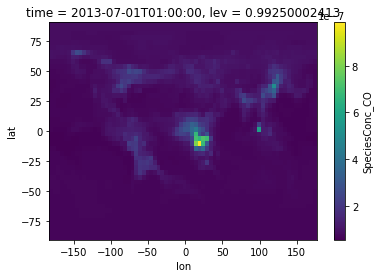

In [4]:
# a quick and dirty plot
ds_nc['SpeciesConc_CO'].isel(time=2, lev=0).plot()

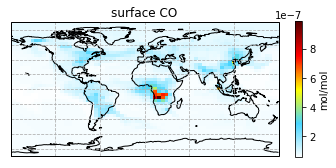

In [5]:
# make it look a bit nicer
fig = plt.figure(figsize=[6, 5])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(linestyle='--')

ds_nc['SpeciesConc_CO'].isel(time=2, lev=0).plot(ax=ax, cmap=WhGrYlRd, 
                                                 cbar_kwargs={'shrink': 0.5, 'label': 'mol/mol'})
ax.set_title('surface CO');

To quickly test this new NC diagnotics module without setting up the latest version of GEOS-Chem on your own, you can use my [GEOS-Chem-on-cloud project](http://cloud-gc.readthedocs.io).

# BPCH diagnostics

This section is mainly for existing GEOS-Chem users. If you just start to learn GEOS-Chem, I recommend skipping this legacy BPCH module and only use the NetCDF diagnotics as shown above.

ND49 (timeseries) is no doubt the most-used BPCH diagnostics. To replicate the same configuration as the NC diag module above, my `input.geos` file would look like:

```
%%% ND49 MENU %%%       :
Turn on ND49 diagnostic : T
Inst 3-D timeser. file  : tsYYYYMMDD.bpch
Tracers to include      : 1 2 4
Frequency [min]         : 20
IMIN, IMAX of region    :   1  72
JMIN, JMAX of region    :   1  46
LMIN, LMAX of region    :   1  72
```

A pre-generated BPCH file is available in this repository. `xbpch.open_bpchdataset()` is able to read BPCH files into xarray formats, so you can use all the xarray skills you've learned to analyze BPCH files!

Since BPCH file is not self-descriptive (unlike NetCDF), you also need to provide `tracerinfo.dat` and `diaginfo.dat` which contain tracer names and other metadata. I added them into this repository, but for your own BPCH data you should use the `*.dat` files in the corresponding run directory so the model versions would match.

In [6]:
ds_bp = xbpch.open_bpchdataset("old-ND49-diagnostics.bpch", 
                               tracerinfo_file='tracerinfo.dat', 
                               diaginfo_file='diaginfo.dat')
ds_bp

<xarray.Dataset>
Dimensions:      (lat: 46, lev: 72, lon: 72, nv: 2, time: 3)
Coordinates:
  * lev          (lev) float64 0.9925 0.9775 0.9624 0.9473 0.9322 0.9171 ...
  * lon          (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 ...
  * lat          (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 ...
  * time         (time) datetime64[ns] 2013-07-01T00:19:41.250000 ...
  * nv           (nv) int64 0 1
Data variables:
    IJ_AVG_S_NO  (time, lon, lat, lev) float32 dask.array<shape=(3, 72, 46, 72), chunksize=(1, 72, 46, 72)>
    time_bnds    (time, nv) datetime64[ns] 2013-07-01T00:19:41.250000 ...
    IJ_AVG_S_O3  (time, lon, lat, lev) float32 dask.array<shape=(3, 72, 46, 72), chunksize=(1, 72, 46, 72)>
    IJ_AVG_S_CO  (time, lon, lat, lev) float32 dask.array<shape=(3, 72, 46, 72), chunksize=(1, 72, 46, 72)>
Attributes:
    modelname:    GEOSFP
    halfpolar:    1
    center180:    1
    res:          (5.0, 4.0)
    Conventions:  CF1.6
    source:       old-ND49-diagn

It is just a normal xarray object! You can do variable selections and any other operations as usual.

In [7]:
ds_bp['IJ_AVG_S_CO']

<xarray.DataArray 'IJ_AVG_S_CO' (time: 3, lon: 72, lat: 46, lev: 72)>
dask.array<shape=(3, 72, 46, 72), dtype=float32, chunksize=(1, 72, 46, 72)>
Coordinates:
  * lev      (lev) float64 0.9925 0.9775 0.9624 0.9473 0.9322 0.9171 0.902 ...
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * time     (time) datetime64[ns] 2013-07-01T00:19:41.250000 ...
Attributes:
    number:          4
    category:        IJ-AVG-$
    name:            CO
    full_name:       CO tracer
    molwt:           0.028
    C:               1
    tracer:          4
    hydrocarbon:     False
    chemical:        True
    original_shape:  (72, 46, 72)
    origin:          (1, 1, 1)
    scale_factor:    1000000000.0
    units:           ppbv

Besides tracers, the BPCH file also contains a variable for time boundaries.

In [8]:
ds_bp['time_bnds']

<xarray.DataArray 'time_bnds' (time: 3, nv: 2)>
array([['2013-07-01T00:19:41.250000000', '2013-07-01T00:19:41.250000000'],
       ['2013-07-01T00:40:18.750000000', '2013-07-01T00:40:18.750000000'],
       ['2013-07-01T01:00:00.000000000', '2013-07-01T01:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:19:41.250000 ...
  * nv       (nv) int64 0 1
Attributes:
    units:    hours since 1985-01-01 00:00:00

It is not too useful, so let's just drop it.

In [9]:
ds_bp = ds_bp.drop('time_bnds')
ds_bp = ds_bp.drop('nv')  # also drop the redundant dimension
ds_bp

# running this cell twice will lead to an error since the variables are already dropped

<xarray.Dataset>
Dimensions:      (lat: 46, lev: 72, lon: 72, time: 3)
Coordinates:
  * lev          (lev) float64 0.9925 0.9775 0.9624 0.9473 0.9322 0.9171 ...
  * lon          (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 ...
  * lat          (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 ...
  * time         (time) datetime64[ns] 2013-07-01T00:19:41.250000 ...
Data variables:
    IJ_AVG_S_NO  (time, lon, lat, lev) float32 dask.array<shape=(3, 72, 46, 72), chunksize=(1, 72, 46, 72)>
    IJ_AVG_S_O3  (time, lon, lat, lev) float32 dask.array<shape=(3, 72, 46, 72), chunksize=(1, 72, 46, 72)>
    IJ_AVG_S_CO  (time, lon, lat, lev) float32 dask.array<shape=(3, 72, 46, 72), chunksize=(1, 72, 46, 72)>
Attributes:
    modelname:    GEOSFP
    halfpolar:    1
    center180:    1
    res:          (5.0, 4.0)
    Conventions:  CF1.6
    source:       old-ND49-diagnostics.bpch
    tracerinfo:   tracerinfo.dat
    diaginfo:     diaginfo.dat
    filetype:     CTM bin 02
    file

Notice that the dimension order is `(time, lon, lat, lev)`, not the common order (time, lev, lat, lon). This is because BPCH has a weird data structure. The order can be corrected by the [transpose()](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.transpose.html) method.


In [10]:
ds_bp = ds_bp.transpose('time', 'lev', 'lat', 'lon')
ds_bp

<xarray.Dataset>
Dimensions:      (lat: 46, lev: 72, lon: 72, time: 3)
Coordinates:
  * lev          (lev) float64 0.9925 0.9775 0.9624 0.9473 0.9322 0.9171 ...
  * lon          (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 ...
  * lat          (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 ...
  * time         (time) datetime64[ns] 2013-07-01T00:19:41.250000 ...
Data variables:
    IJ_AVG_S_NO  (time, lev, lat, lon) float32 dask.array<shape=(3, 72, 46, 72), chunksize=(1, 72, 46, 72)>
    IJ_AVG_S_O3  (time, lev, lat, lon) float32 dask.array<shape=(3, 72, 46, 72), chunksize=(1, 72, 46, 72)>
    IJ_AVG_S_CO  (time, lev, lat, lon) float32 dask.array<shape=(3, 72, 46, 72), chunksize=(1, 72, 46, 72)>
Attributes:
    modelname:    GEOSFP
    halfpolar:    1
    center180:    1
    res:          (5.0, 4.0)
    Conventions:  CF1.6
    source:       old-ND49-diagnostics.bpch
    tracerinfo:   tracerinfo.dat
    diaginfo:     diaginfo.dat
    filetype:     CTM bin 02
    file

People often want to convert BPCH data to NC format. Since xarray is a universal interface to different formats, such a conversion is trivial:

In [11]:
ds_bp = xbpch.common.fix_attr_encoding(ds_bp) # fix a bug mentioned at http://xbpch.readthedocs.io/en/latest/usage.html#save-to-netcdf
ds_bp.to_netcdf('from_bpch.nc')

We do get a fully-fledged NetCDF file!

In [12]:
!ncdump -h from_bpch.nc

netcdf from_bpch {
dimensions:
	lev = 72 ;
	lon = 72 ;
	lat = 46 ;
	time = 3 ;
variables:
	double lev(lev) ;
		lev:_FillValue = NaN ;
		lev:standard_name = "atmosphere_hybrid_sigma_pressure_coordinate" ;
		lev:axis = "Z" ;
	double lon(lon) ;
		lon:_FillValue = NaN ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
	double lat(lat) ;
		lat:_FillValue = NaN ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
	float IJ_AVG_S_NO(time, lev, lat, lon) ;
		IJ_AVG_S_NO:_FillValue = NaNf ;
		IJ_AVG_S_NO:number = 1LL ;
		IJ_AVG_S_NO:category = "IJ-AVG-$" ;
		IJ_AVG_S_NO:name = "NO" ;
		IJ_AVG_S_NO:full_name = "NO tracer" ;
		IJ_AVG_S_NO:molwt = 0.03 ;
		IJ_AVG_S_NO:C = 1LL ;
		IJ_AVG_S_NO:tracer = 1LL ;
		IJ_AVG_S_NO:hydrocarbon = 0LL ;
		IJ_AVG_S_NO:chemical = 1LL ;
		IJ_AVG_S_NO:original_shape = 72LL, 46LL, 72LL ;
		IJ_AVG_S_NO:origin = 1LL, 1LL, 1LL ;
		IJ_AVG_S_NO:scale_factor = 1000000000. ;
	double time(time) ;
		time:_FillValue = NaN ;
		time:bounds = "time_bnds

# Comparing two formats

Finally, we can compare BPCH and NetCDF diagnostics to make sure they are the same:

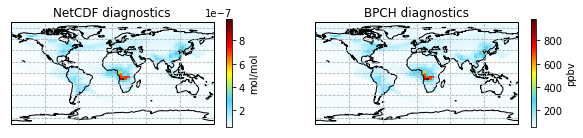

In [13]:
fig, axes = plt.subplots(1, 2, figsize=[10, 4], subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the previous NetCDF diagnostics on the left side
ds_nc['SpeciesConc_CO'].isel(time=2, lev=0).plot(ax=axes[0], cmap=WhGrYlRd, 
                                                 cbar_kwargs={'shrink': 0.5, 'label': 'mol/mol'})
axes[0].set_title('NetCDF diagnostics')


# Plot BPCH diagnotics on the right side
ds_bp['IJ_AVG_S_CO'].isel(time=2, lev=0).plot(ax=axes[1], cmap=WhGrYlRd, 
                                              cbar_kwargs={'shrink': 0.5, 'label': 'ppbv'})

axes[1].set_title('BPCH diagnostics')

for ax in axes:
    ax.coastlines()
    ax.gridlines(linestyle='--')

They look pretty much the same (although the units are different). A more rigorous comparison can be done by `np.allclose()`

In [14]:
# notice the unit conversion
np.allclose(ds_nc['SpeciesConc_CO']*1e9, ds_bp['IJ_AVG_S_CO'], rtol=1e-5)

True

With the relative error tolerance of 1e-5 (0.001%), two data fields are the same. But they are not bit-wise identical, due to inevitable numerical noise.

In [15]:
# Don't be to strict! 1e-6 is too small.
np.allclose(ds_nc['SpeciesConc_CO']*1e9, ds_bp['IJ_AVG_S_CO'], rtol=1e-6)

False